In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "yy_quadh"

In [5]:
altfile='yy_quadh_bkg10_soft025_md_{base}'
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.full_signal_list) ])

# bkg = ObjIter([])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List), Tree(module.Run2_UL18.TTJets)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]


In [6]:
reslist = ['h1y1','h2y1']

In [7]:
def load_reco_ranks(t, model=eightb.models.yy_quadh_bkg10_soft025_md):
    ranker = eightb.load_weaver_output(t, model=model.path, fields=['scores','mass_rank','nres_rank']+[f'{res}_m' for res in reslist])
    rename = dict(
        scores='reco_rank'
    ).get

    t.extend(
        **{
            rename(key,key):ak.from_regular(array)
            for key,array in ranker.items()
        }
    )

(signal+bkg).apply(load_reco_ranks)

[None, None, None, None, None]

In [8]:

t8btag = CollectionFilter('jet', filter=lambda t: ak_rank(-t.jet_btag, axis=-1) < 8)

signal = signal.apply(t8btag)
bkg = bkg.apply(t8btag)
data = data.apply(t8btag)

In [9]:
event_filter = FilterSequence(
    eightb.selected_jet_pt(),
    eightb.selected_jet_btagwp()
)

signal = signal.apply(event_filter)
bkg = bkg.apply(event_filter)
data = data.apply(event_filter)

In [20]:
class sample_rank(ObjTransform):
    def __call__(self, rank):
        sample = ak.from_regular(np.random.randint(315, size=(len(rank), self.n)))
        return rank[sample]

# $$ \text{mass rank} = 1 - \exp(-\frac{1}{2}\sum_{i=1}^4(\frac{m_i-125}{25})^2)$$ 

100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


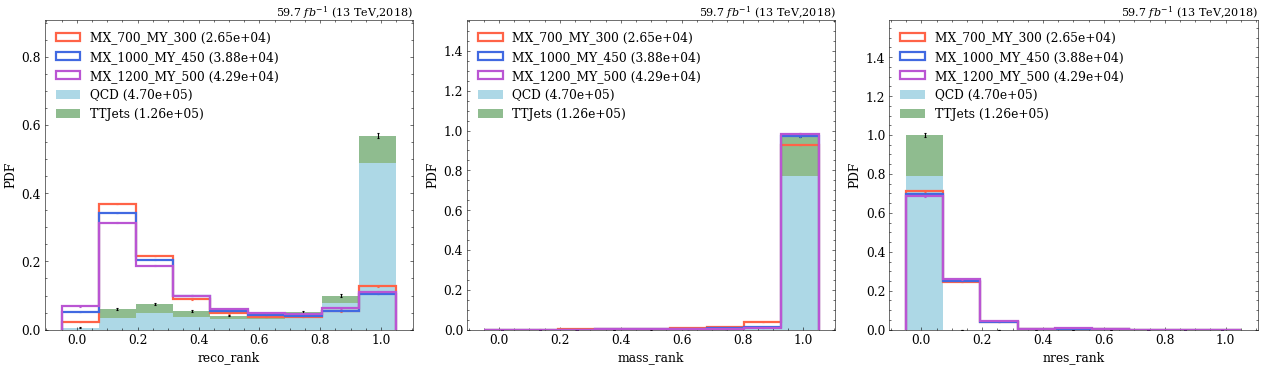

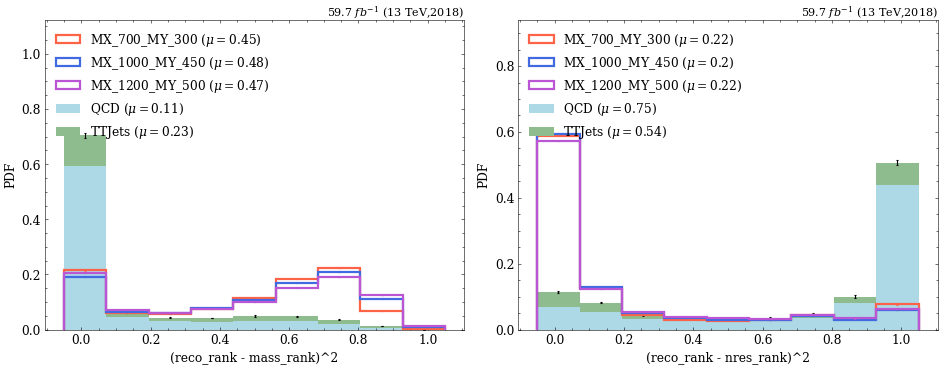

In [21]:
study.quick( 
    signal + bkg,
    legend=True,
    transforms=sample_rank(n=10),
    varlist=['reco_rank','mass_rank','nres_rank'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
)
study.quick( 
    signal + bkg,
    legend=True, h_label_stat='mean',
    transforms=sample_rank(n=10),
    varlist=[lambda t : (t.reco_rank - t.mass_rank)**2,lambda t : (t.reco_rank - t.nres_rank)**2],
    xlabels=['(reco_rank - mass_rank)^2','(reco_rank - nres_rank)^2'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
)

In [24]:
(signal+bkg).apply(lambda t : t.extend(_sample=ak.from_regular(np.random.randint(315, size=(len(t), 10)))))

[None, None, None, None, None]

100%|██████████| 1/1 [00:13<00:00, 13.71s/it]


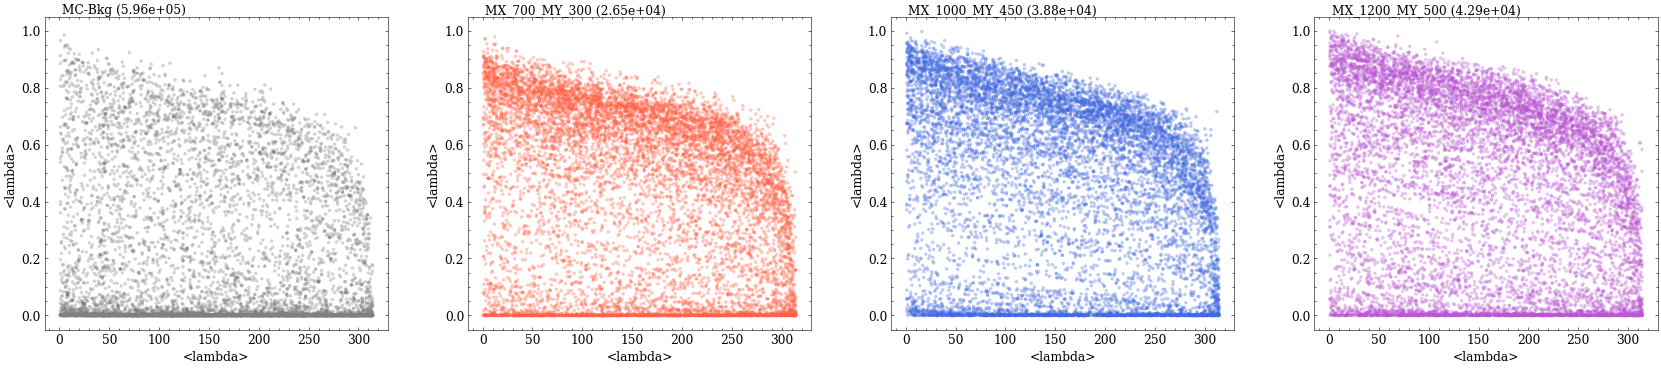

In [72]:
study.quick2d( 
    signal + bkg,
    legend=True,
    # transforms=sample_rank(n=10),
    varlist=[lambda t:ak_rank(t.reco_rank)[t._sample],lambda t:(t.reco_rank - t.mass_rank)[t._sample]**2],
    binlist=[(0,315,30),(0,1,30)],
    efficiency=True,
    scatter=True,
    # exe=plot_histo2d_x_corr,
    dim=-1,
)

100%|██████████| 1/1 [00:12<00:00, 12.12s/it]


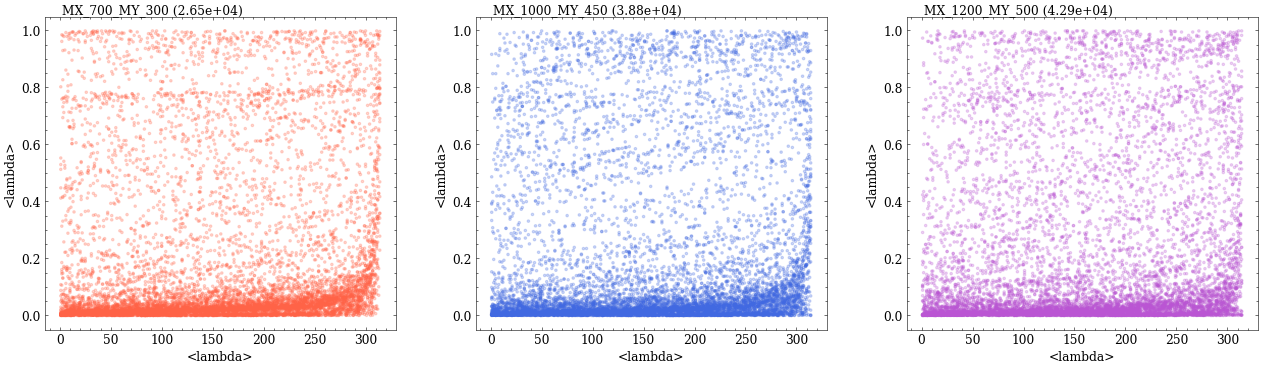

In [73]:
study.quick2d( 
    signal,
    legend=True,
    # transforms=sample_rank(n=10),
    varlist=[lambda t:ak_rank(t.reco_rank)[t._sample],lambda t:(t.reco_rank - t.nres_rank)[t._sample]**2],
    binlist=[(0,315,30),(0,1,30)],
    efficiency=True,
    scatter=True,
    # exe=plot_histo2d_x_corr,
    dim=-1,
)

100%|██████████| 1/1 [00:12<00:00, 12.93s/it]


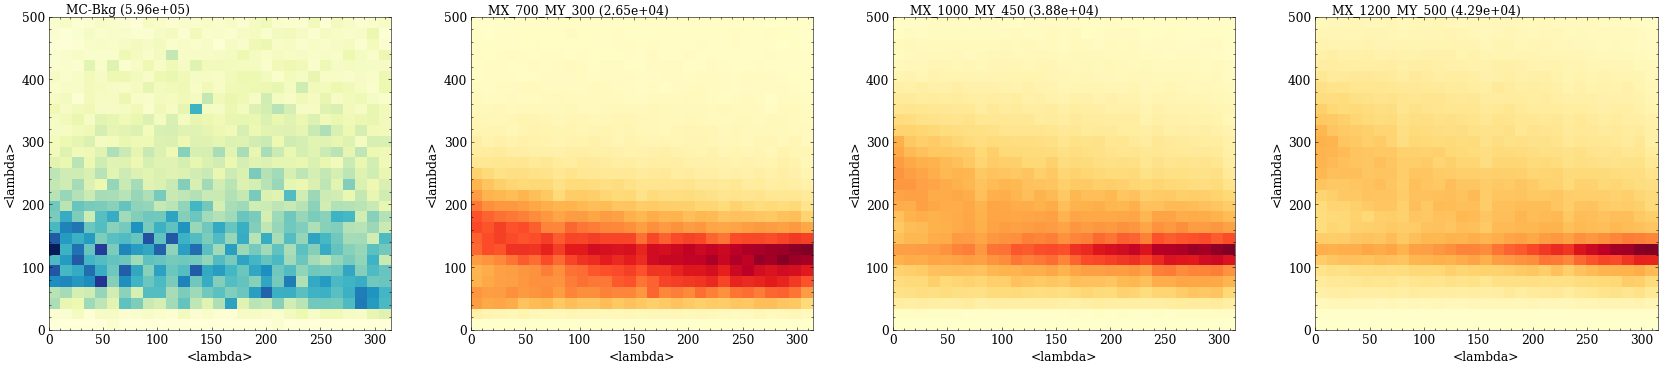

In [ ]:
study.quick2d( 
    signal + bkg,
    legend=True,
    # transforms=sample_rank(n=10),
    varlist=[lambda t:ak_rank(t.reco_rank)[t._sample],lambda t:t.h1y1_m[t._sample]],
    binlist=[(0,315,30),(0,500,30)],
    efficiency=True,
    # scatter=dict(alpha=0.1,fraction=10000),
    # exe=plot_histo2d_x_corr,
    dim=-1,
)

100%|██████████| 2/2 [00:02<00:00,  1.17s/it]


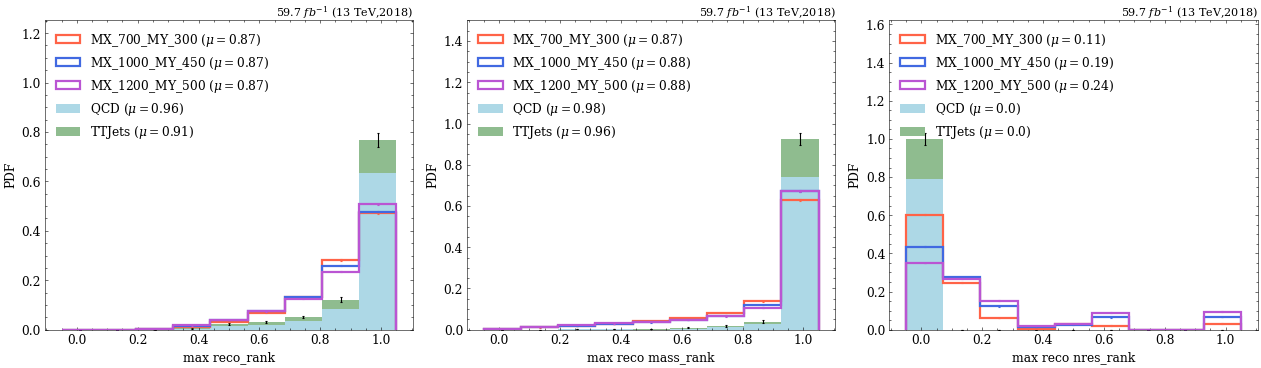

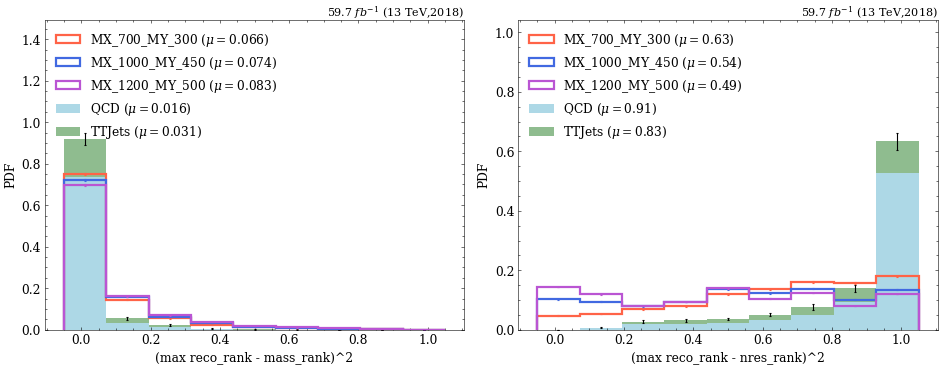

In [12]:
study.quick( 
    signal + bkg,
    legend=True, h_label_stat='mean',
    varlist=[lambda t : (t.reco_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ],lambda t : (t.mass_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ],lambda t : (t.nres_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ]],
    xlabels=['max reco_rank','max reco mass_rank','max reco nres_rank'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
)
study.quick( 
    signal + bkg,
    legend=True, h_label_stat='mean',
    varlist=[lambda t : (t.reco_rank - t.mass_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ]**2,lambda t : (t.reco_rank - t.nres_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ]**2],
    xlabels=['(max reco_rank - mass_rank)^2','(max reco_rank - nres_rank)^2'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
)

100%|██████████| 2/2 [00:02<00:00,  1.14s/it]


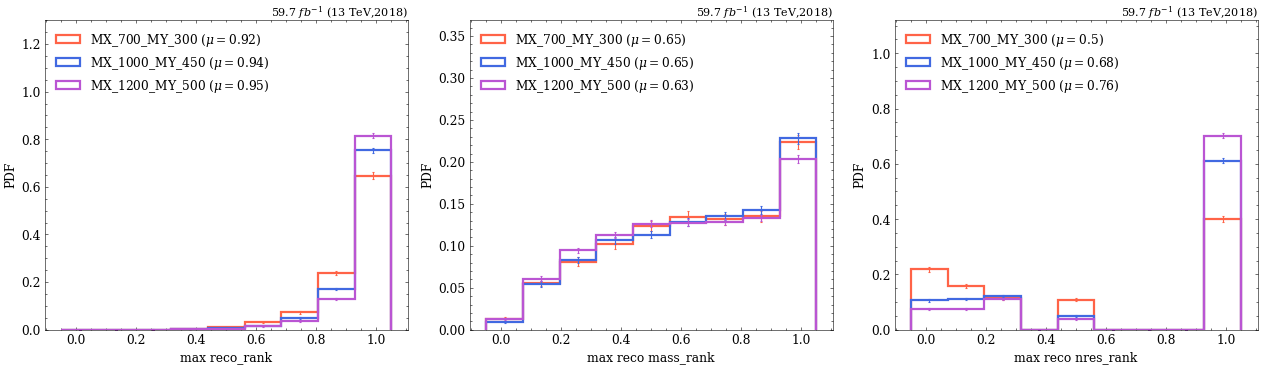

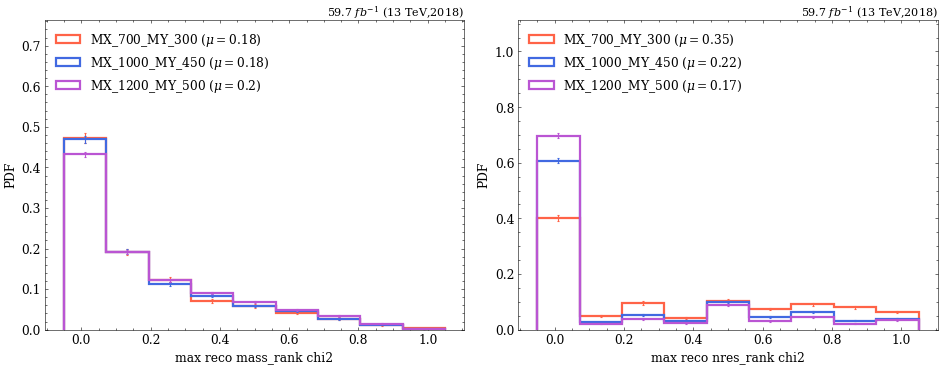

In [13]:
study.quick( 
    signal,
    masks=lambda t : t.nfound_select==8,
    legend=True, h_label_stat='mean',
    varlist=[lambda t : (t.reco_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ],lambda t : (t.mass_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ],lambda t : (t.nres_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ]],
    xlabels=['max reco_rank','max reco mass_rank','max reco nres_rank'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
)

study.quick( 
    signal,
    masks=lambda t : t.nfound_select==8,
    legend=True, h_label_stat='mean',
    varlist=[lambda t : (t.reco_rank - t.mass_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ]**2,lambda t : (t.reco_rank - t.nres_rank)[ ak.argmax(t.reco_rank,axis=-1,keepdims=True) ]**2],
    xlabels=['max reco mass_rank chi2','max reco nres_rank chi2'],
    binlist=[(-0.05,1.05,10)]*3,
    efficiency=True,
    dim=-1,
)

In [14]:
def ordered_reco(t):

    order = ak.argsort(t.reco_rank,axis=-1,ascending=False)
    reco_ord = dict(
        reco_ord_rank=t.reco_rank[order],
        **{
            f'reco_ord_{res.lower()}_m': t[f'{res.lower()}_m'][order]
            for res in ['h1y1','h2y1']
        }
    )

    t.extend(
        **reco_ord
    )
(signal+bkg).apply(ordered_reco)

[None, None, None, None, None]

100%|██████████| 4/4 [00:00<00:00,  5.46it/s]


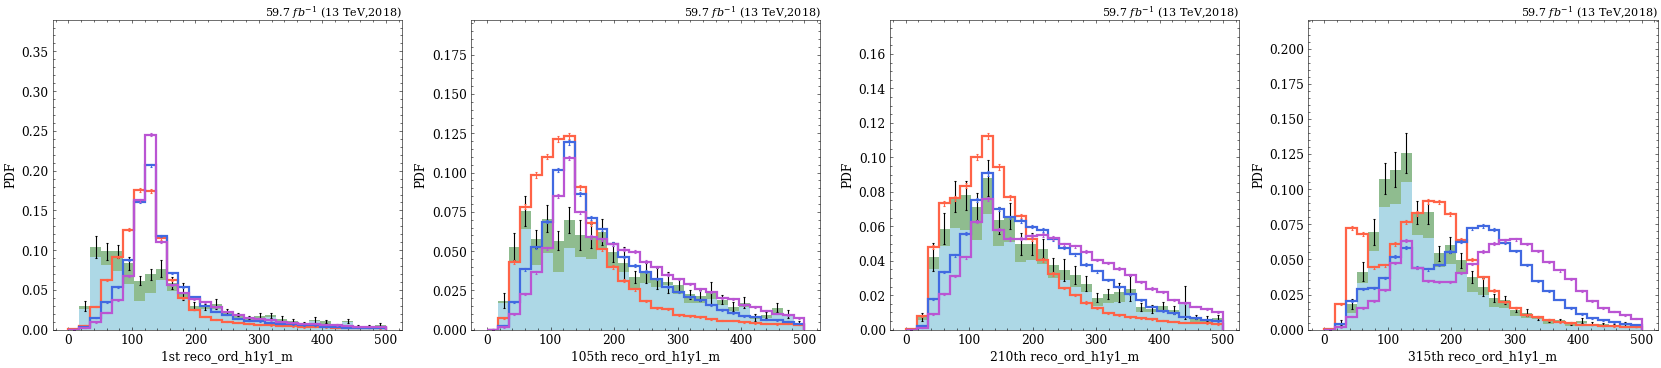

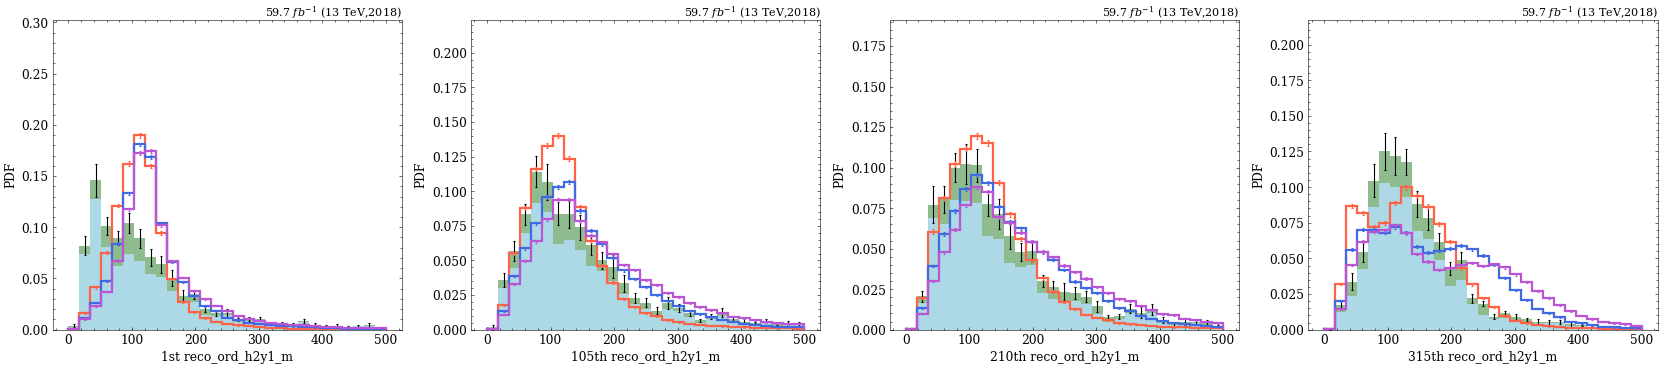

In [15]:
recos=np.linspace(0,314,4).astype(int)



for res in reslist:
    bins=(0,500,30)
    study.quick( 
        signal+bkg,
        efficiency=True,
        varlist=[ f'reco_ord_{res.lower()}_m[:,{i}]' for i in recos],
        binlist=[bins]*len(recos),
        dim=-1,
    )

100%|██████████| 2/2 [00:00<00:00,  3.27it/s]


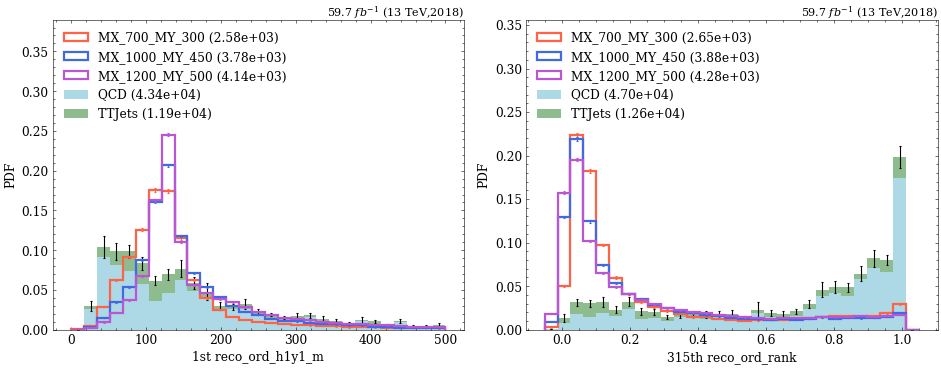

In [122]:
study.quick( 
    signal + bkg,
    legend=True,
    varlist = [f'reco_ord_h1y1_m[:,0]',f'reco_ord_rank[:,314]', ],
    binlist=[(0,500,30),(-0.05,1.05,30),  ],
    efficiency=True
)

100%|██████████| 2/2 [00:00<00:00,  6.93it/s]


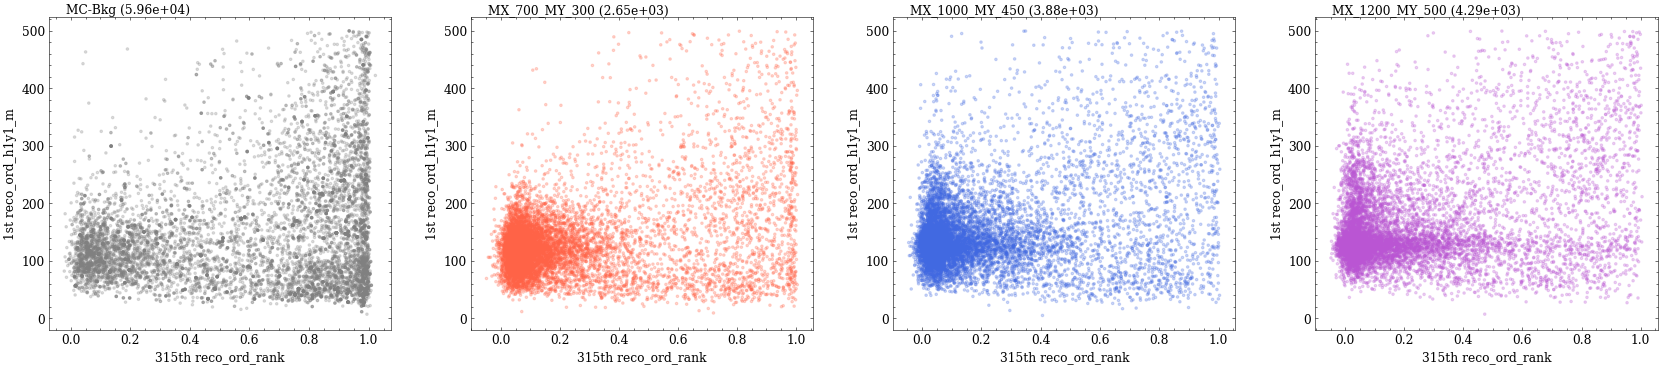

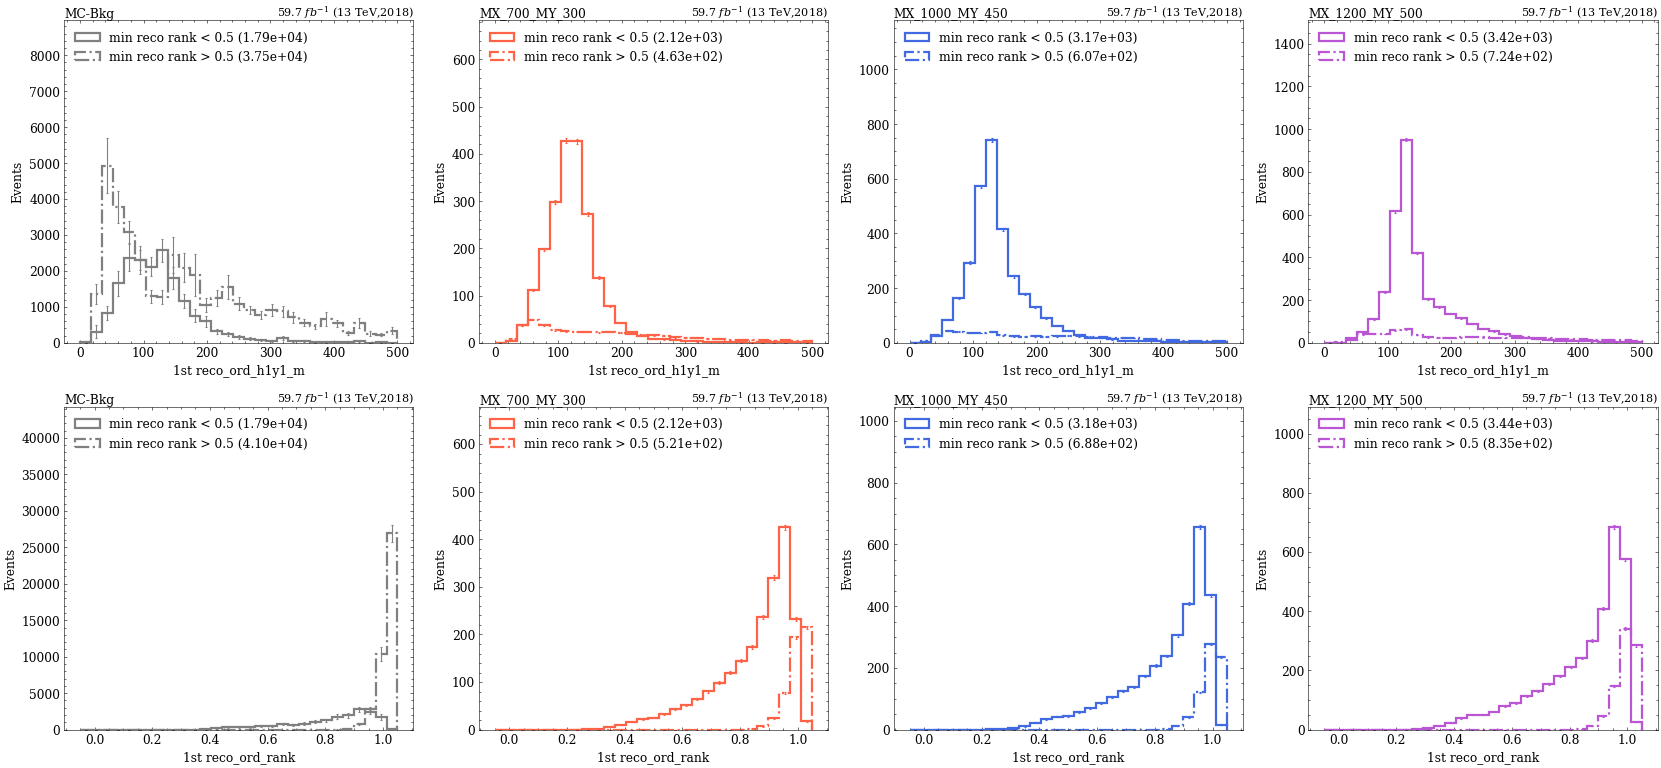

In [119]:
study.quick2d( 
    signal + bkg,
    legend=True,
    varlist = [f'reco_ord_rank[:,314]',f'reco_ord_h1y1_m[:,0]', ],
    binlist=[(-0.05,1.05,30), (0,500,30), ],
    scatter=True,
)

study.compare_masks(
    signal,bkg,
    masks=[lambda t : (t.reco_ord_rank[:,314]<0.5),lambda t : (0.5<t.reco_ord_rank[:,314])],
    label=['min reco rank < 0.5','min reco rank > 0.5'],
    legend=True,
    varlist=['reco_ord_h1y1_m[:,0]','reco_ord_rank[:,0]'],
    binlist=[(0,500,30),(0-0.05,1.05,30)]
)

100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


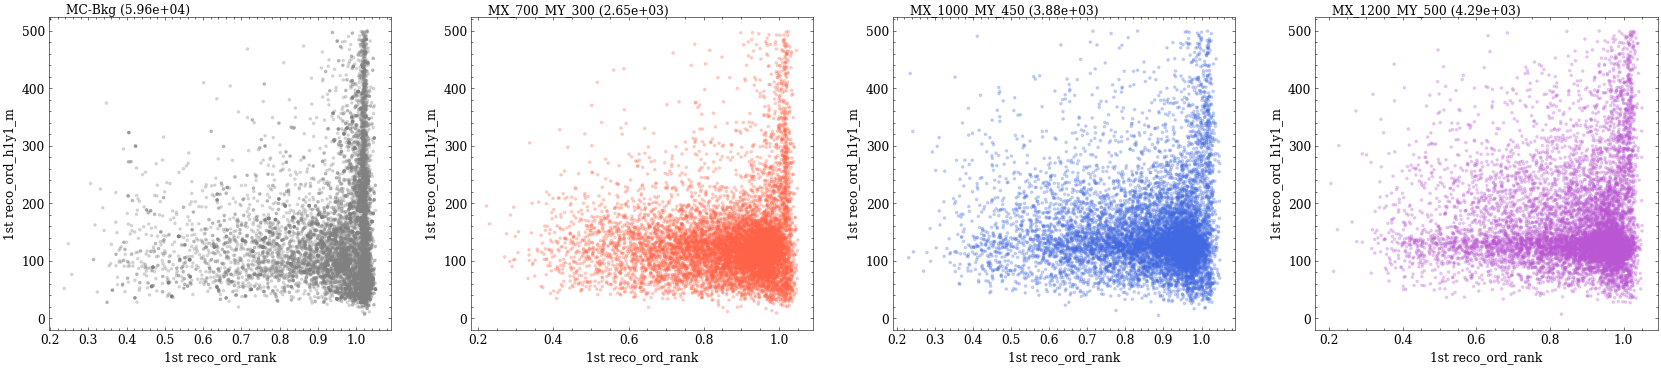

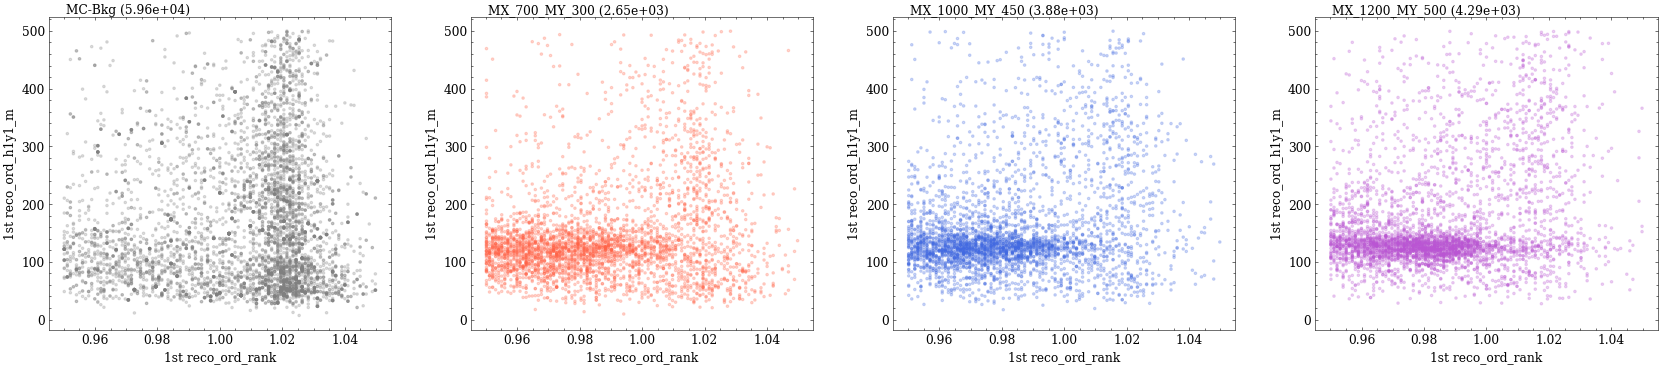

In [125]:
study.quick2d( 
    signal + bkg,
    legend=True,
    varlist = [f'reco_ord_rank[:,0]',f'reco_ord_h1y1_m[:,0]', ],
    binlist=[(-0.05,1.05,30), (0,500,30), ],
    scatter=True,
)

study.quick2d( 
    signal + bkg,
    legend=True,
    varlist = [f'reco_ord_rank[:,0]',f'reco_ord_h1y1_m[:,0]', ],
    binlist=[(0.95,1.05,30), (0,500,30), ],
    scatter=True,
)

100%|██████████| 1/1 [00:02<00:00,  2.36s/it]


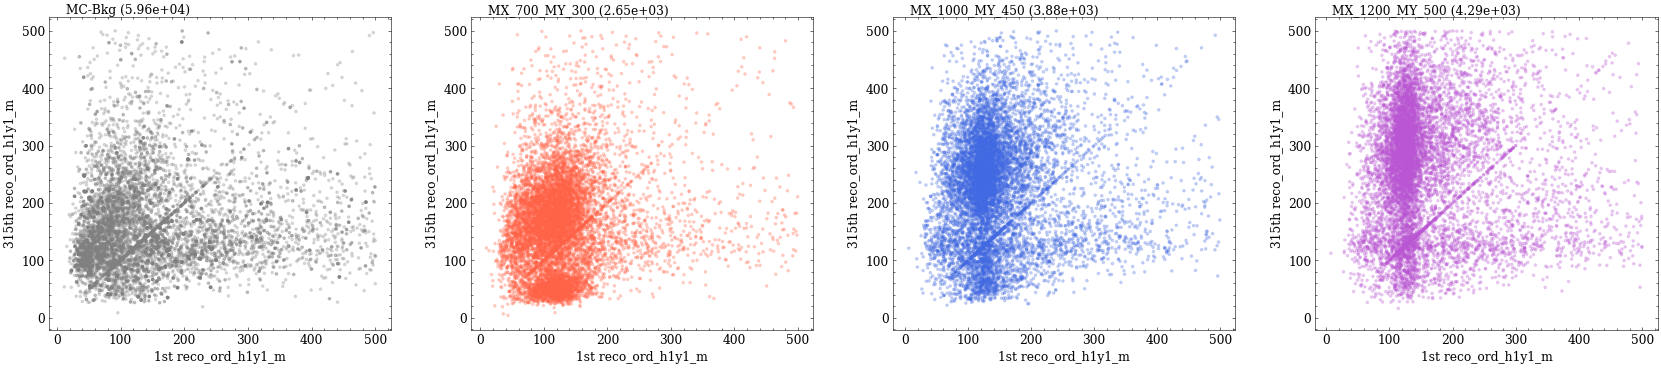

In [126]:
study.quick2d( 
    signal + bkg,
    legend=True,
    varlist = [f'reco_ord_h1y1_m[:,0]',f'reco_ord_h1y1_m[:,314]', ],
    binlist=[(0,500,30), (0,500,30), ],
    scatter=True,
)

In [81]:
recos=np.linspace(0,314,315).astype(int)

for i in tqdm(recos[150:]):
    study.quick( 
        signal + bkg,
        legend=True, h_label_stat='mean',
        varlist=[f'reco_ord_h1y1_m[:,{i}]', f'reco_ord_rank[:,{i}]'],
        grid=True,
        binlist=[(0,500,30), (-0.05,1.05,30)],
        efficiency=True,
        ylim=(0,0.4),
        saveas=f'yy_quadh/gif/reco_ord_{i:03}',
        report=False,
    )
# plt.show()

100%|██████████| 165/165 [05:31<00:00,  2.01s/it]
